This notebook trains a model on the regional health data to predict the 2023 cases. This model includes epidemiological and climate data. 

To generate the predictions for the state, the model is applied to the data of each regional health, and the 100 predictions generated by each of them are summed to generate the predictions of the state.  

In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_bi_lstm, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
 
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

'''
This script is used to train the model for a specific STATE and forecast the cases on a 
specific year (TEST_YEAR). The model is trained  with the regional health data before the year selected. 
'''
STATE = 'MG'
TEST_YEAR = 2023


In [2]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
df.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
date,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False


In [3]:
code_to_state = {33: 'RJ', 32: 'ES', 41: 'PR', 23: 'CE', 21: 'MA',
 31: 'MG', 42: 'SC', 26: 'PE', 25: 'PB', 24: 'RN', 22: 'PI', 27: 'AL',
 28: 'SE', 35: 'SP', 43: 'RS', 15: 'PA', 16: 'AP', 14: 'RR',  11: 'RO',
 13: 'AM', 12: 'AC', 51: 'MT', 50: 'MS', 52: 'GO', 17: 'TO', 53: 'DF',
 29: 'BA'}

In [21]:
state_to_code = {state: code for code, state in code_to_state.items()}

state_to_code

{'RJ': 33,
 'ES': 32,
 'PR': 41,
 'CE': 23,
 'MA': 21,
 'MG': 31,
 'SC': 42,
 'PE': 26,
 'PB': 25,
 'RN': 24,
 'PI': 22,
 'AL': 27,
 'SE': 28,
 'SP': 35,
 'RS': 43,
 'PA': 15,
 'AP': 16,
 'RR': 14,
 'RO': 11,
 'AM': 13,
 'AC': 12,
 'MT': 51,
 'MS': 50,
 'GO': 52,
 'TO': 17,
 'DF': 53,
 'BA': 29}

In [4]:
df_clima = prep.load_climate_data()

df_clima = df_clima.loc[df_clima.geocode.astype(str).str[:2] == '31']
df_clima.head()

,date,epiweek,geocode,temp_min,temp_med,temp_max,precip_tot,rel_humid_med,temp_amp
2244,2009-12-27,200952,3100104,20.7208,23.4406,27.3525,5.5421,84.8923,6.6317
2245,2009-12-27,200952,3100203,21.2028,24.3718,28.6233,0.8166,79.5011,7.4205
2246,2009-12-27,200952,3100302,20.0611,23.8270,28.7545,0.9051,78.3925,8.6934
2247,2009-12-27,200952,3100401,18.9060,22.3913,27.7191,2.7522,79.8940,8.8131
2248,2009-12-27,200952,3100500,20.1577,24.5404,29.9290,0.5607,75.4242,9.7713


In [5]:
df_end = df.merge(df_clima, left_on = ['date', 'epiweek', 'geocode'], right_on = ['date', 'epiweek', 'geocode'])

df_end.date = pd.to_datetime(df_end.date)

df_end.set_index('date', inplace = True)

df_end.head()

,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2,temp_min,temp_med,temp_max,precip_tot,rel_humid_med,temp_amp
date,,,,,,,,,,,,,,,,,,,
2010-01-03,2010,201001,0,3110806,Itambacuri,31096,Nordeste,3111,MG,True,True,False,False,21.9829,26.5957,32.0409,0.1879,69.7659,10.0580
2010-01-03,2010,201001,0,3132404,Itajubá,31003,Sul,3101,MG,True,True,False,False,18.5711,22.3066,27.3997,3.1666,78.2605,8.8286
2010-01-03,2010,201001,0,3168903,São Gotardo,31082,Noroeste,3109,MG,True,True,False,False,19.2286,23.4808,28.1682,1.6369,75.2743,8.9396
2010-01-03,2010,201001,0,3155405,Juiz de Fora,31097,Sudeste,3107,MG,True,True,False,False,22.1361,26.4140,31.8807,0.9042,75.2398,9.7446
2010-01-03,2010,201001,0,3170602,Piumhi,31093,Sul,3101,MG,True,True,False,False,19.4717,23.8841,28.7656,0.7958,73.9370,9.2939


In [6]:
enso = prep.load_sea_indicators()

enso.head()

,enso,iod,pdo,epiweek_label,epiweek,year
date,,,,,,
2010-01-10,1.230226,-0.419708,-0.115554,201014,14,2010
2010-01-17,1.070318,-0.443917,0.061606,201015,15,2010
2010-01-24,0.957734,-0.154522,0.207900,201016,16,2010
2010-01-31,1.210819,-0.069680,0.385610,201017,17,2010
2010-02-07,1.210819,-0.069680,0.385610,201018,18,2010


In [7]:
# generate the samples to train and test based on the regional data 
columns_to_normalize = ['casos', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso', 'iod', 'pdo']

X_train, y_train = prep.generate_regional_train_samples(df_end, enso, TEST_YEAR, columns_to_normalize, True)

In [8]:
X_train.shape

(801, 52, 19)

In [9]:
batch_size = 4
LOSS = 'msle'
model_name = 'bi_lstm'
activation = 'sigmoid'

In [10]:
model = build_bi_lstm( hidden=128, loss = LOSS, 
                      features=19, predict_n=52, look_back=52, batch_size = batch_size, optimizer = Adam(learning_rate = 0.001),
                     activation = activation)
model

/opt/homebrew/Caskroom/miniforge/base/envs/train_lstm/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 52, 19)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (4, 52, 128)           │       151,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (4, 52, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 52, 128)           │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 52, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (4, 128)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         6,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,428 (1.61 MB)

 Trainable params: 421,428 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [11]:
%%time 
model = train_model_using_cross_val(model, X_train, y_train, n_splits=4, epochs = 5,
                                verbose = 1,
                                batch_size = batch_size, 
                                monitor = 'val_loss',
                                min_delta = 0,
                                patience = 10)

Training fold 1...
Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.0326 - loss: 0.0650 - mape: 47149584.0000 - mse: 0.0885 - val_accuracy: 0.0000e+00 - val_loss: 0.0147 - val_mape: 5794566.5000 - val_mse: 0.0188
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.0701 - loss: 0.0113 - mape: 6662348.5000 - mse: 0.0128 - val_accuracy: 0.0547 - val_loss: 0.0126 - val_mape: 1767786.8750 - val_mse: 0.0184
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.0598 - loss: 0.0096 - mape: 5438208.5000 - mse: 0.0124 - val_accuracy: 0.0647 - val_loss: 0.0114 - val_mape: 2346555.5000 - val_mse: 0.0180
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.0713 - loss: 0.0078 - mape: 4862099.0000 - mse: 0.0109 - val_accuracy: 0.0746 - val_loss: 0.0106 - val_mape: 5767275.0000 - val_mse: 0.0169
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.0748 - loss: 0.0080 - mape: 5665569.0000 - mse: 0.0118 - val_accuracy: 0.0796 - val_lo

In [12]:
model.save(f'./saved_models/region_model_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

In [13]:
%%time
df_preds = sum_regions_predictions(model, df_end, enso, TEST_YEAR, columns_to_normalize)

df_preds.head()

CPU times: user 27min 19s, sys: 31.5 s, total: 27min 50s
Wall time: 2h 29min 52s


,dates,lower,preds,upper
0,2022-10-09,39.810022,65.178906,136.106801
1,2022-10-16,88.877831,124.479178,228.851454
2,2022-10-23,155.670828,228.995557,429.427543
3,2022-10-30,226.490634,321.449900,627.420744
4,2022-11-06,129.377331,191.964323,423.812757


In [15]:
df_preds.to_csv(f'./predictions/preds_region_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)

In [18]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
df = df[['casos']].resample('W-SUN').sum()
df.head()

,casos
date,
2010-01-03,2794
2010-01-10,3729
2010-01-17,4656
2010-01-24,6195
2010-01-31,7179


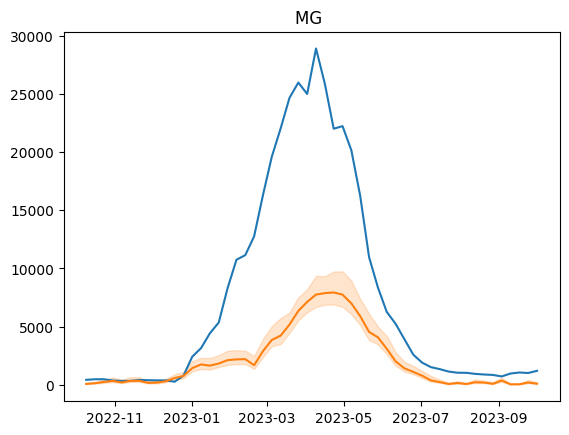

In [20]:
fig, ax = plt.subplots()

ax.plot(df.loc[df.index.isin(df_preds.dates)].casos, label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds', color = 'tab:orange')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG ')

plt.show()